In [2]:
import numpy as np
import paddle as paddle
import paddle.fluid as fluid
from PIL import Image
import matplotlib.pyplot as plt
import os

In [3]:
# step1 准备数据
BUF_SIZE=512
BATCH_SIZE=128
#用于训练的数据提供器，每次从缓存中随机读取批次大小的数据
train_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.mnist.train(),
                          buf_size=BUF_SIZE),
    batch_size=BATCH_SIZE)
#用于训练的数据提供器，每次从缓存中随机读取批次大小的数据
test_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.mnist.test(),
                          buf_size=BUF_SIZE),
    batch_size=BATCH_SIZE)
#用于打印，查看mnist数据
train_data=paddle.dataset.mnist.train();
sampledata=next(train_data())
print(sampledata)

[==================================================]ist/train-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-images-idx3-ubyte.gz
[==================================================]ist/train-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-labels-idx1-ubyte.gz
[==================================================]ist/t10k-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/t10k-images-idx3-ubyte.gz
[==================================================]ist/t10k-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/t10k-labels-idx1-ubyte.gz


(array([-1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1. 

In [5]:
# step2 配置网络

# 2.1 定义多层感知器 
def multilayer_perceptron(input): 
    # 第一个全连接层，激活函数为ReLU 
    hidden1 = fluid.layers.fc(input=input, size=100, act='relu') 
    # 第二个全连接层，激活函数为ReLU 
    hidden2 = fluid.layers.fc(input=hidden1, size=100, act='relu') 
    # 以softmax为激活函数的全连接输出层，输出层的大小必须为数字的个数10 
    prediction = fluid.layers.fc(input=hidden2, size=10, act='softmax') 
    return prediction

# 2.2 定义数据层
# 输入的原始图像数据，大小为1*28*28
image = fluid.layers.data(name='image', shape=[1, 28, 28], dtype='float32')#单通道，28*28像素值
# 标签，名称为label,对应输入图片的类别标签
label = fluid.layers.data(name='label', shape=[1], dtype='int64')#图片标签

# 2.3 获取分类器
predict = multilayer_perceptron(image)

# 2.4 定义损失函数和准确率
#使用交叉熵损失函数,描述真实样本标签和预测概率之间的差值
cost = fluid.layers.cross_entropy(input=predict, label=label)  
# 使用类交叉熵函数计算predict和label之间的损失函数
avg_cost = fluid.layers.mean(cost)
# 计算分类准确率
acc = fluid.layers.accuracy(input=predict, label=label)

# 2.5 定义优化函数
 #使用Adam算法进行优化, learning_rate 是学习率(它的大小与网络的训练收敛速度有关系)
optimizer = fluid.optimizer.AdamOptimizer(learning_rate=0.001)  
opts = optimizer.minimize(avg_cost)

Pass:0, Batch:0, Cost:2.89294, Accuracy:0.04688
Pass:0, Batch:200, Cost:0.21839, Accuracy:0.92188
Pass:0, Batch:400, Cost:0.28749, Accuracy:0.90625
Test:0, Cost:0.22984, Accuracy:0.93018
Pass:1, Batch:0, Cost:0.21215, Accuracy:0.94531
Pass:1, Batch:200, Cost:0.07116, Accuracy:0.98438
Pass:1, Batch:400, Cost:0.10716, Accuracy:0.97656
Test:1, Cost:0.16275, Accuracy:0.94719
save models to ./model/hand.inference.model
训练模型保存完成！


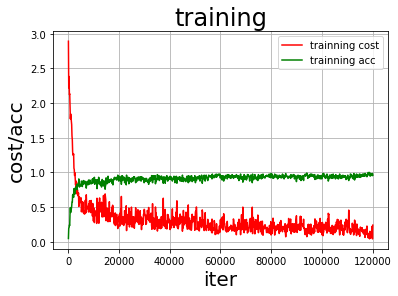

In [6]:
# step3 模型训练与模型评估

# 定义使用CPU还是GPU，使用CPU时use_cuda = False,使用GPU时use_cuda = True
use_cuda = False
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
# 获取测试程序
test_program = fluid.default_main_program().clone(for_test=True)
# Executor:接收传入的program，通过run()方法运行program
exe = fluid.Executor(place)
exe.run(fluid.default_startup_program())

#DataFeeder负责将数据提供器（train_reader,test_reader）返回的数据转成一种特殊的数据结构，使其可以输入到Executor中
feeder = fluid.DataFeeder(place=place, feed_list=[image, label])

all_train_iter=0
all_train_iters=[]
all_train_costs=[]
all_train_accs=[]

def draw_train_process(title,iters,costs,accs,label_cost,label_acc):
    """
    label_cost, label_acc 为图例名称
    """
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel("cost/acc", fontsize=20)
    plt.plot(iters, costs,color='red',label=label_cost) 
    plt.plot(iters, accs,color='green',label=label_acc) 
    plt.legend()  # 图例
    plt.grid()  # 网格
    plt.show()
    
EPOCH_NUM=2
for pass_id in range(EPOCH_NUM):
    # 进行训练
    for batch_id, data in enumerate(train_reader()):                         #遍历train_reader
        train_cost, train_acc = exe.run(program=fluid.default_main_program(),#运行主程序
                                        feed=feeder.feed(data),              #给模型喂入数据
                                        fetch_list=[avg_cost, acc])          #fetch 误差、准确率  
        
        all_train_iter=all_train_iter+BATCH_SIZE
        all_train_iters.append(all_train_iter)
        
        all_train_costs.append(train_cost[0])
        all_train_accs.append(train_acc[0])
        
        # 每200个batch打印一次信息  误差、准确率
        if batch_id % 200 == 0:
            # pass_id:当前是第几个epoch,batch_id:当前是第几个batch
            print('Pass:%d, Batch:%d, Cost:%0.5f, Accuracy:%0.5f' %
                  (pass_id, batch_id, train_cost[0], train_acc[0]))
    
    # 每训练一个epoch，进行一次测试
    test_accs = []
    test_costs = []
    for batch_id, data in enumerate(test_reader()):                         #遍历test_reader
        test_cost, test_acc = exe.run(program=test_program, #执行训练程序
                                      feed=feeder.feed(data),               #喂入数据
                                      fetch_list=[avg_cost, acc])           #fetch 误差、准确率
        test_accs.append(test_acc[0])                                       #每个batch的准确率
        test_costs.append(test_cost[0])                                     #每个batch的误差
        
       
    # 求测试结果的平均值
    test_cost = (sum(test_costs) / len(test_costs))                         #每轮的平均误差
    test_acc = (sum(test_accs) / len(test_accs))                            #每轮的平均准确率
    print('Test:%d, Cost:%0.5f, Accuracy:%0.5f' % (pass_id, test_cost, test_acc))

# 所有 epoch 训练结束
#保存模型
# 如果保存路径不存在就创建
model_save_dir = "./model/hand.inference.model"
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
print ('save models to %s' % (model_save_dir))
fluid.io.save_inference_model(model_save_dir,   #保存推理model的路径
                                  ['image'],    #推理（inference）需要 feed 的数据
                                  [predict],    #保存推理（inference）结果的 Variables
                                  exe)             #executor 保存 inference model

print('训练模型保存完成！')
draw_train_process("training",all_train_iters,all_train_costs,all_train_accs,"trainning cost","trainning acc")